In [ ]:
import zipfile
import numpy as np
import os

# === Step 1: Set up ZIP file name and extraction folder ===
zip_path = '/content/D15_100_data_4096_1.zip'          # <-- Replace with your actual ZIP file name
extract_dir = 'unzipped_txt_files'  # Folder where files will be extracted

# === Step 2: Extract all files from the ZIP ===
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# === Step 3: Read each .txt file into a NumPy array ===
arrays = {}  # Dictionary to hold filename: array pairs

for filename in os.listdir(extract_dir):
    if filename.endswith('.txt'):
        file_path = os.path.join(extract_dir, filename)
        array = np.loadtxt(file_path)  # Assumes 1D array: one number per line
        arrays[filename] = array

In [ ]:
pbt = np.loadtxt('/content/unzipped_txt_files/D15_100_pbt_4096.txt')
RHX1234 = np.loadtxt('/content/unzipped_txt_files/D15_100_RH1234_4096_hcross.txt')
RHP1234 = np.loadtxt('/content/unzipped_txt_files/D15_100_RH1234_4096_hplus.txt')
RHX12 = np.loadtxt('/content/unzipped_txt_files/D15_100_RH12_4096_hcross.txt')
RHP12 = np.loadtxt('/content/unzipped_txt_files/D15_100_RH12_4096_hplus.txt')
RHX34 = np.loadtxt('/content/unzipped_txt_files/D15_100_RH34_4096_hcross.txt')
RHP34 = np.loadtxt('/content/unzipped_txt_files/D15_100_RH34_4096_hplus.txt')
RHXT = np.loadtxt('/content/unzipped_txt_files/D15_100_RHT_4096_hcross.txt')
RHPT = np.loadtxt('/content/unzipped_txt_files/D15_100_RHT_4096_hplus.txt')

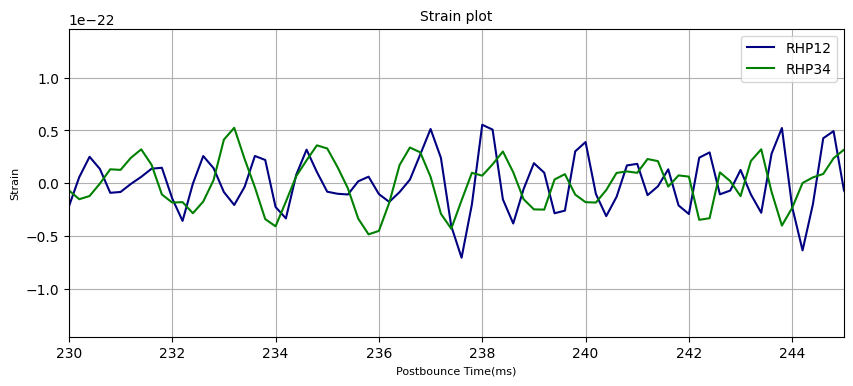

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(pbt,RHP12,color='navy', label='RHP12')
plt.plot(pbt,RHP34,color='green', label='RHP34')
plt.xlim(left=230, right=245)
#plt.ylim((-5,5))
plt.xlabel("Postbounce Time(ms)", fontsize=8)
plt.ylabel("Strain", fontsize=8)
plt.title("Strain plot", fontsize=10)
plt.grid(True)
plt.legend()
plt.show()

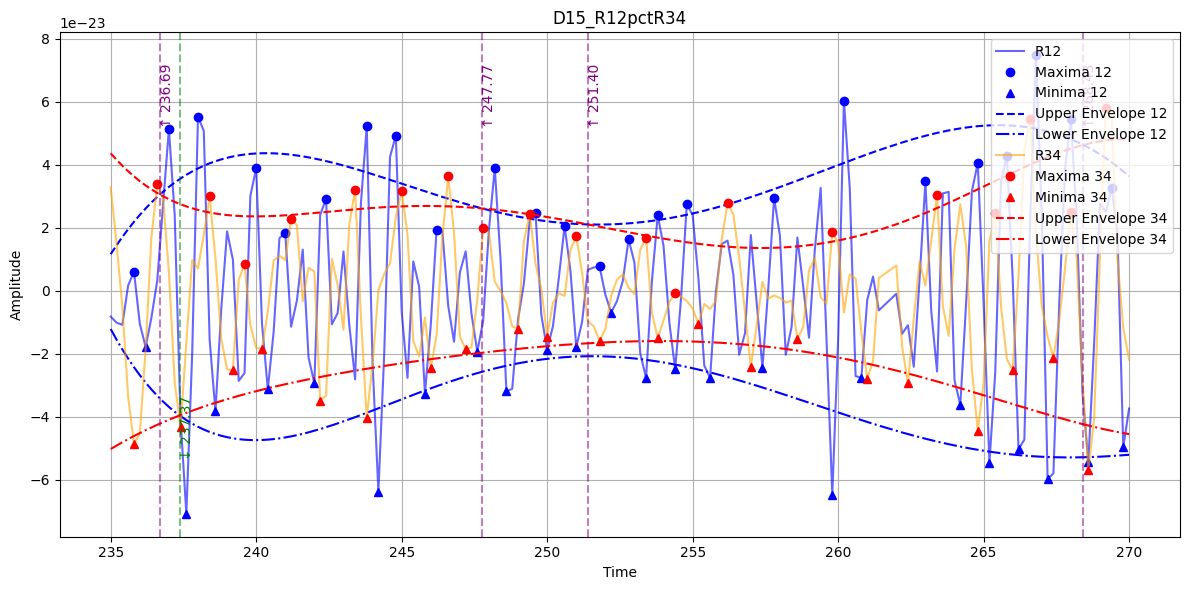

Upper envelope intersections at times:
  236.6926
  247.7691
  251.4041
  268.4281

Lower envelope intersections at times:
  237.3681


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from numpy.polynomial import Polynomial

# ------------------------
# Simulated signals
# ------------------------
time = pbt
signal1 = RHP12
signal2 = RHP34

# ------------------------
# Time window
# ------------------------
start_time = 235
end_time = 270
mask = (time >= start_time) & (time <= end_time)
time_window = time[mask]

# ------------------------
# Envelope fitting function
# ------------------------
def get_envelopes(t, sig, degree=5, order=4):
    max_idx = argrelextrema(sig, np.greater, order=order)[0]
    min_idx = argrelextrema(sig, np.less, order=order)[0]

    t_max, s_max = t[max_idx], sig[max_idx]
    t_min, s_min = t[min_idx], sig[min_idx]

    upper_poly = Polynomial.fit(t_max, s_max, deg=degree)
    lower_poly = Polynomial.fit(t_min, s_min, deg=degree)

    return upper_poly(t), lower_poly(t), t_max, s_max, t_min, s_min

# ------------------------
# Get envelopes for both signals
# ------------------------
sig1_win = signal1[mask]
sig2_win = signal2[mask]

env1_upper, env1_lower, t1_max, s1_max, t1_min, s1_min = get_envelopes(time_window, sig1_win)
env2_upper, env2_lower, t2_max, s2_max, t2_min, s2_min = get_envelopes(time_window, sig2_win)

# ------------------------
# Find intersections
# ------------------------
def find_intersections(t, y1, y2):
    diff = y1 - y2
    signs = np.sign(diff)
    zero_crossings = np.where(np.diff(signs))[0]
    t_crossings = []

    for i in zero_crossings:
        # Linear interpolation for more precise crossing time
        t0, t1 = t[i], t[i + 1]
        y0, y1_ = diff[i], diff[i + 1]
        slope = (y1_ - y0) / (t1 - t0)
        if slope != 0:
            t_cross = t0 - y0 / slope
            t_crossings.append(t_cross)

    return t_crossings

# Compute intersection times
upper_intersections = find_intersections(time_window, env1_upper, env2_upper)
lower_intersections = find_intersections(time_window, env1_lower, env2_lower)

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(12, 6))

# Signal 1
plt.plot(time_window, sig1_win, label='R12', color='blue', alpha=0.6)
plt.plot(t1_max, s1_max, 'bo', label='Maxima 12')
plt.plot(t1_min, s1_min, 'b^', label='Minima 12')
plt.plot(time_window, env1_upper, 'b--', label='Upper Envelope 12')
plt.plot(time_window, env1_lower, 'b-.', label='Lower Envelope 12')

# Signal 2
plt.plot(time_window, sig2_win, label='R34', color='orange', alpha=0.6)
plt.plot(t2_max, s2_max, 'ro', label='Maxima 34')
plt.plot(t2_min, s2_min, 'r^', label='Minima 34')
plt.plot(time_window, env2_upper, 'r--', label='Upper Envelope 34')
plt.plot(time_window, env2_lower, 'r-.', label='Lower Envelope 34')

# Plot intersection points
for t_cross in upper_intersections:
    plt.axvline(t_cross, color='purple', linestyle='--', alpha=0.5)
    plt.text(t_cross, max(np.max(env1_upper), np.max(env2_upper)), f'↑ {t_cross:.2f}', color='purple', rotation=90)

for t_cross in lower_intersections:
    plt.axvline(t_cross, color='green', linestyle='--', alpha=0.5)
    plt.text(t_cross, min(np.min(env1_lower), np.min(env2_lower)), f'↓ {t_cross:.2f}', color='green', rotation=90)

plt.title(f"D15_R12pctR34")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("D15_R12pctR34.png",dpi=400)
plt.show()

# ------------------------
# Output intersection times
# ------------------------
print("Upper envelope intersections at times:")
for t in upper_intersections:
    print(f"  {t:.4f}")

print("\nLower envelope intersections at times:")
for t in lower_intersections:
    print(f"  {t:.4f}")


2 times taken are 236.6926 ms & 237.3681 ms

In [ ]:
avgp = (236.6926+237.3681)/2
print(avgp)

237.03035


Avg time of crossing for plus = 237.0304 ms

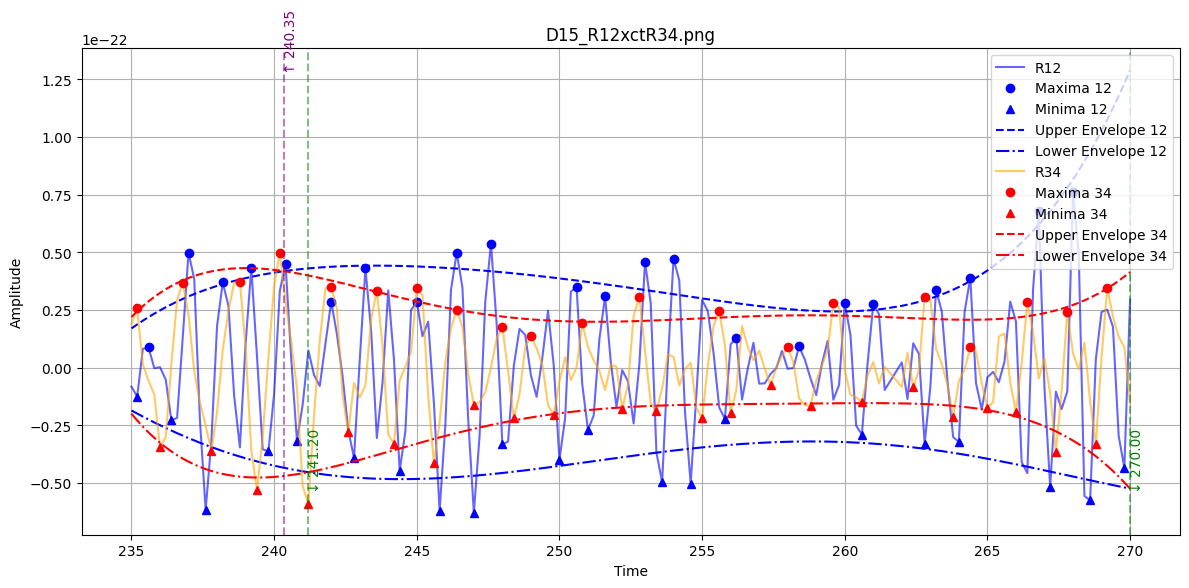

Upper envelope intersections at times:
  240.3462

Lower envelope intersections at times:
  241.1980
  269.9953


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from numpy.polynomial import Polynomial

# ------------------------
# Simulated signals
# ------------------------
time = pbt
signal1 = RHX12
signal2 = RHX34

# ------------------------
# Time window
# ------------------------
start_time = 235
end_time = 270
mask = (time >= start_time) & (time <= end_time)
time_window = time[mask]

# ------------------------
# Envelope fitting function
# ------------------------
def get_envelopes(t, sig, degree=5, order=4):
    max_idx = argrelextrema(sig, np.greater, order=order)[0]
    min_idx = argrelextrema(sig, np.less, order=order)[0]

    t_max, s_max = t[max_idx], sig[max_idx]
    t_min, s_min = t[min_idx], sig[min_idx]

    upper_poly = Polynomial.fit(t_max, s_max, deg=degree)
    lower_poly = Polynomial.fit(t_min, s_min, deg=degree)

    return upper_poly(t), lower_poly(t), t_max, s_max, t_min, s_min

# ------------------------
# Get envelopes for both signals
# ------------------------
sig1_win = signal1[mask]
sig2_win = signal2[mask]

env1_upper, env1_lower, t1_max, s1_max, t1_min, s1_min = get_envelopes(time_window, sig1_win)
env2_upper, env2_lower, t2_max, s2_max, t2_min, s2_min = get_envelopes(time_window, sig2_win)

# ------------------------
# Find intersections
# ------------------------
def find_intersections(t, y1, y2):
    diff = y1 - y2
    signs = np.sign(diff)
    zero_crossings = np.where(np.diff(signs))[0]
    t_crossings = []

    for i in zero_crossings:
        # Linear interpolation for more precise crossing time
        t0, t1 = t[i], t[i + 1]
        y0, y1_ = diff[i], diff[i + 1]
        slope = (y1_ - y0) / (t1 - t0)
        if slope != 0:
            t_cross = t0 - y0 / slope
            t_crossings.append(t_cross)

    return t_crossings

# Compute intersection times
upper_intersections = find_intersections(time_window, env1_upper, env2_upper)
lower_intersections = find_intersections(time_window, env1_lower, env2_lower)

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(12, 6))

# Signal 1
plt.plot(time_window, sig1_win, label='R12', color='blue', alpha=0.6)
plt.plot(t1_max, s1_max, 'bo', label='Maxima 12')
plt.plot(t1_min, s1_min, 'b^', label='Minima 12')
plt.plot(time_window, env1_upper, 'b--', label='Upper Envelope 12')
plt.plot(time_window, env1_lower, 'b-.', label='Lower Envelope 12')

# Signal 2
plt.plot(time_window, sig2_win, label='R34', color='orange', alpha=0.6)
plt.plot(t2_max, s2_max, 'ro', label='Maxima 34')
plt.plot(t2_min, s2_min, 'r^', label='Minima 34')
plt.plot(time_window, env2_upper, 'r--', label='Upper Envelope 34')
plt.plot(time_window, env2_lower, 'r-.', label='Lower Envelope 34')

# Plot intersection points
for t_cross in upper_intersections:
    plt.axvline(t_cross, color='purple', linestyle='--', alpha=0.5)
    plt.text(t_cross, max(np.max(env1_upper), np.max(env2_upper)), f'↑ {t_cross:.2f}', color='purple', rotation=90)

for t_cross in lower_intersections:
    plt.axvline(t_cross, color='green', linestyle='--', alpha=0.5)
    plt.text(t_cross, min(np.min(env1_lower), np.min(env2_lower)), f'↓ {t_cross:.2f}', color='green', rotation=90)

plt.title(f"D15_R12xctR34.png")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("D15_R12xctR34.png",dpi=400)
plt.show()

# ------------------------
# Output intersection times
# ------------------------
print("Upper envelope intersections at times:")
for t in upper_intersections:
    print(f"  {t:.4f}")

print("\nLower envelope intersections at times:")
for t in lower_intersections:
    print(f"  {t:.4f}")


2 times taken are 240.3462 ms & 241.1980 ms

In [ ]:
avgx = (240.3462+241.1980)/2
print(avgx)

240.77210000000002


Avg time of crossing for cross = 240.7721 ms

# **Spectrograms**

# Plus

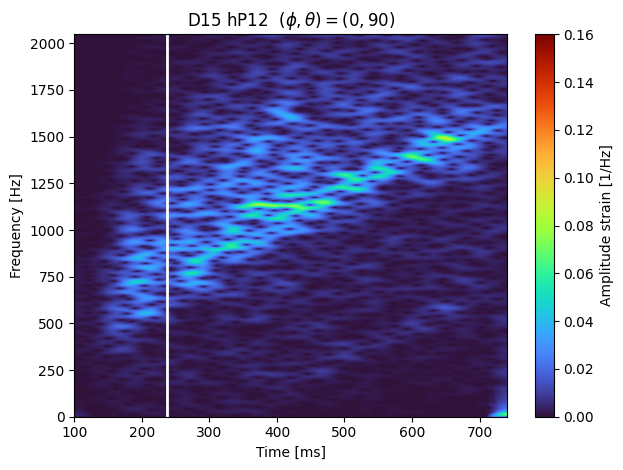

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (0.0, np.pi / 2.0)  # Equator
pct = 237.0304

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, RHP12, kind='linear', bounds_error=False, fill_value=(RHP12[0], RHP12[-1]))
uniform_RHP12 = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_RHP12, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(pct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
plt.xlim([min(pbt), max(pbt)])
plt.title(r"{0:s} hP12  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, phi_eq * 180.0 / np.pi, theta_eq * 180.0 / np.pi))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHP12_.png")
plt.show()

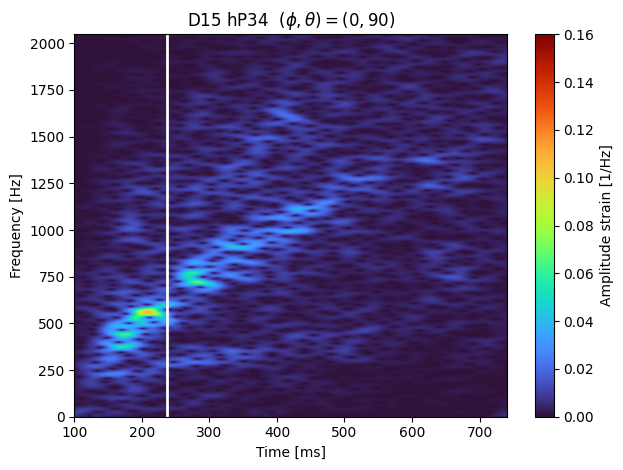

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (0.0, np.pi / 2.0)  # Equator
pct = 237.0304

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, RHP34, kind='linear', bounds_error=False, fill_value=(RHP34[0], RHP34[-1]))
uniform_RHP34 = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_RHP34, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(pct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
plt.xlim([min(pbt), max(pbt)])
plt.title(r"{0:s} hP34  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, phi_eq * 180.0 / np.pi, theta_eq * 180.0 / np.pi))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHP34_.png")
plt.show()

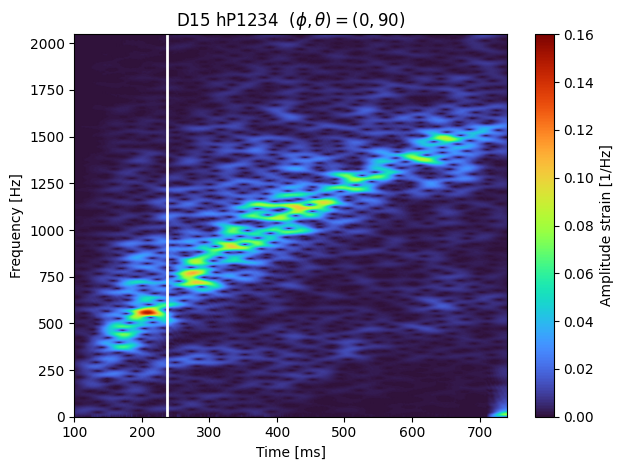

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (0.0, np.pi / 2.0)  # Equator
pct = 237.0304

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, RHP1234, kind='linear', bounds_error=False, fill_value=(RHP1234[0], RHP1234[-1]))
uniform_RHP1234 = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_RHP1234, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(pct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
plt.xlim([min(pbt), max(pbt)])
plt.title(r"{0:s} hP1234  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, phi_eq * 180.0 / np.pi, theta_eq * 180.0 / np.pi))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHP1234_.png")
plt.show()

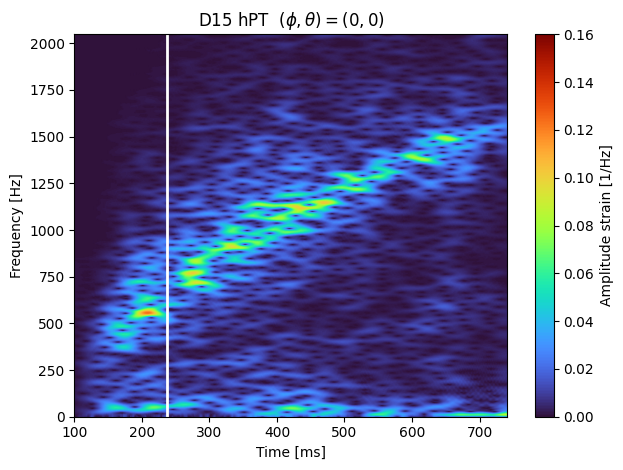

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (0.0, 0.0)  # Equator
pct = 237.0304

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, RHPT, kind='linear', bounds_error=False, fill_value=(RHPT[0], RHPT[-1]))
uniform_RHPT = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_RHPT, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(pct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
plt.xlim([min(pbt), max(pbt)])
plt.title(r"{0:s} hPT  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, phi_eq * 180.0 / np.pi, theta_eq * 180.0 / np.pi))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHPT_.png",dpi=400)
plt.show()

# Cross

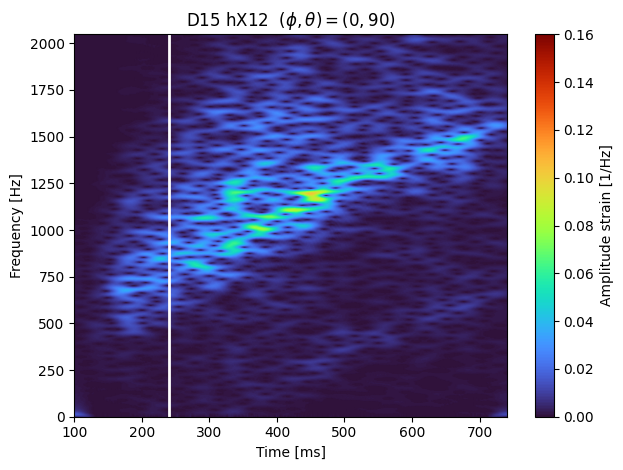

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (0.0, np.pi / 2.0)  # Equator
xct = 240.7721

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, RHX12, kind='linear', bounds_error=False, fill_value=(RHX12[0], RHX12[-1]))
uniform_RHX12 = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_RHX12, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(xct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
plt.xlim([min(pbt), max(pbt)])
plt.title(r"{0:s} hX12  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, phi_eq * 180.0 / np.pi, theta_eq * 180.0 / np.pi))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHX12_.png")
plt.show()

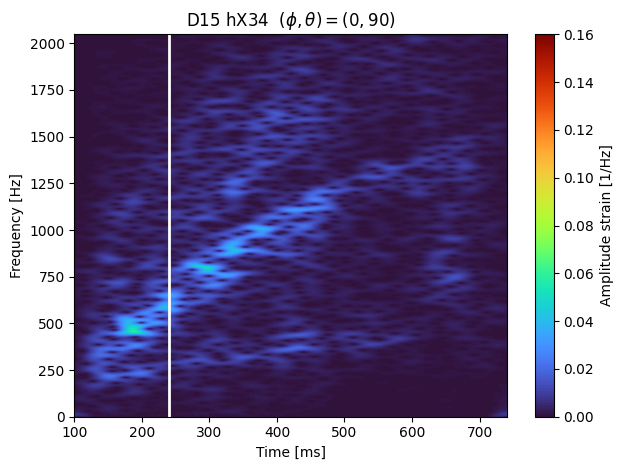

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (0.0, np.pi / 2.0)  # Equator
xct = 240.7721

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, RHX34, kind='linear', bounds_error=False, fill_value=(RHX34[0], RHX34[-1]))
uniform_RHX34 = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_RHX34, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(xct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
plt.xlim([min(pbt), max(pbt)])
plt.title(r"{0:s} hX34  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, phi_eq * 180.0 / np.pi, theta_eq * 180.0 / np.pi))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHX34_.png")
plt.show()

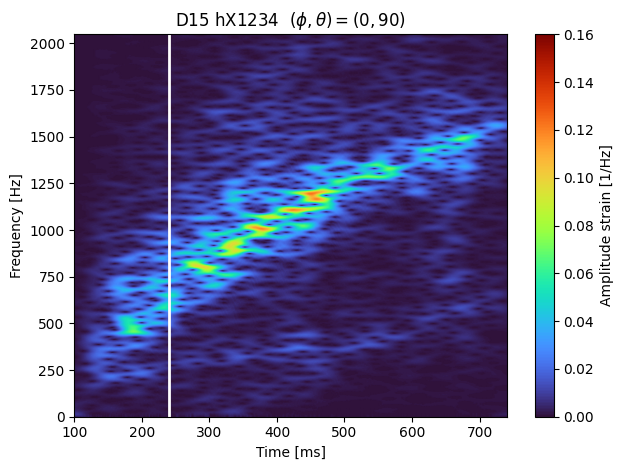

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (0.0, np.pi / 2.0)  # Equator
xct = 240.7721

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, RHX1234, kind='linear', bounds_error=False, fill_value=(RHX1234[0], RHX1234[-1]))
uniform_RHX1234 = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_RHX1234, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(xct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
plt.xlim([min(pbt), max(pbt)])
plt.title(r"{0:s} hX1234  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, phi_eq * 180.0 / np.pi, theta_eq * 180.0 / np.pi))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHX1234_.png")
plt.show()

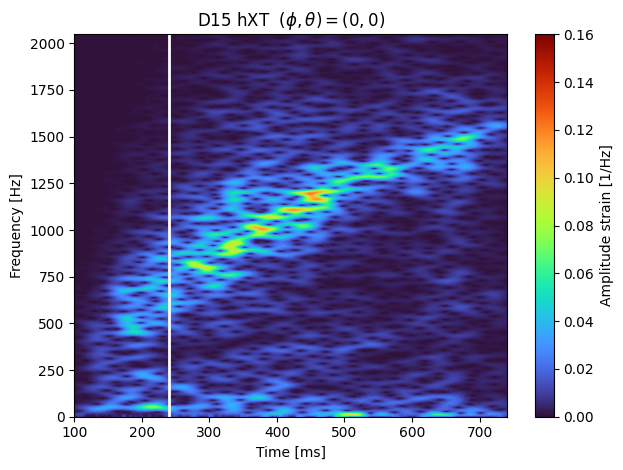

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (0.0, 0.0)  # Equator
xct = 240.7721

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, RHXT, kind='linear', bounds_error=False, fill_value=(RHXT[0], RHXT[-1]))
uniform_RHXT = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_RHXT, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(xct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
plt.xlim([min(pbt), max(pbt)])
plt.title(r"{0:s} hXT  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, phi_eq * 180.0 / np.pi, theta_eq * 180.0 / np.pi))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHXT_.png",dpi=400)
plt.show()

# **30Theta60Phi**

In [ ]:
import pandas as pd
with open('/content/D15_strain_theta30_phi60.txt','r') as f:
    lines = f.readlines()[1:]
data1=[[float(x) for x in line.split()]for line in lines]
df1 = pd.DataFrame(data1,columns=['pbt3060','rh+t3060','rhxt3060'])
print(df1.head())

    pbt3060  rh+t3060  rhxt3060
0  2.000261 -0.018226 -0.051442
1  2.200650 -0.132801  0.052106
2  2.400654 -0.132669  0.052756
3  2.600044 -0.133049  0.053728
4  2.800372 -0.132670  0.052965


In [ ]:
pbt3060 = df1['pbt3060'].to_numpy()
print(pbt3060)
rhpt3060 = df1['rh+t3060'].to_numpy()
print(rhpt3060)
rhxt3060 = df1['rhxt3060'].to_numpy()
print(rhxt3060)

[  2.0002608   2.2006504   2.400654  ... 741.0003    741.20015
 741.40061  ]
[-0.01822569 -0.13280126 -0.13266945 ... -6.49720207 -4.50298923
 -6.00205525]
[-0.05144234  0.0521056   0.05275648 ... -1.70804337 -0.98449062
 -2.4106892 ]


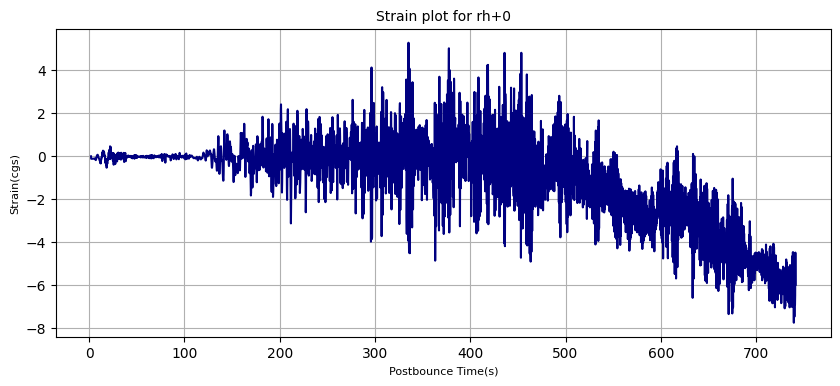

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(pbt3060,rhpt3060,color='navy')
#plt.xlim(left=100, right=740)
plt.xlabel("Postbounce Time(s)", fontsize=8)
plt.ylabel("Strain(cgs)", fontsize=8)
plt.title("Strain plot for rh+0", fontsize=10)
plt.grid(True)
plt.show()

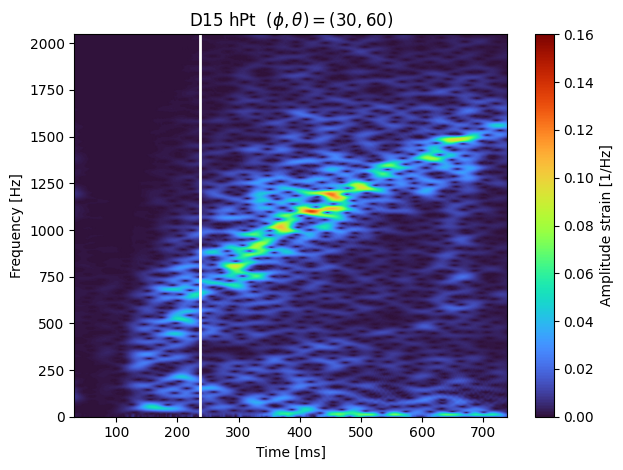

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (np.pi /6.0, np.pi / 3.0)  # Equator
pct = 237.0304

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt3060 / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, rhpt3060, kind='linear', bounds_error=False, fill_value=(rhpt3060[0], rhpt3060[-1]))
uniform_rhpt3060 = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_rhpt3060, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(pct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
#plt.xlim([min(pbt3060), max(pbt3060)])
plt.title(r"{0:s} hPt  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, phi_eq * 180.0 / np.pi, theta_eq * 180.0 / np.pi))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHPT_3060.png",dpi=400)
plt.show()

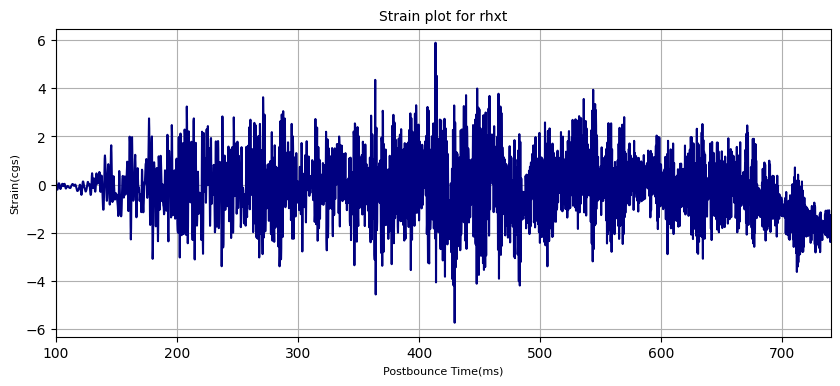

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(pbt3060,rhxt3060,color='navy')
plt.xlim(left=100, right=740)
plt.xlabel("Postbounce Time(ms)", fontsize=8)
plt.ylabel("Strain(cgs)", fontsize=8)
plt.title("Strain plot for rhxt", fontsize=10)
plt.grid(True)
plt.show()

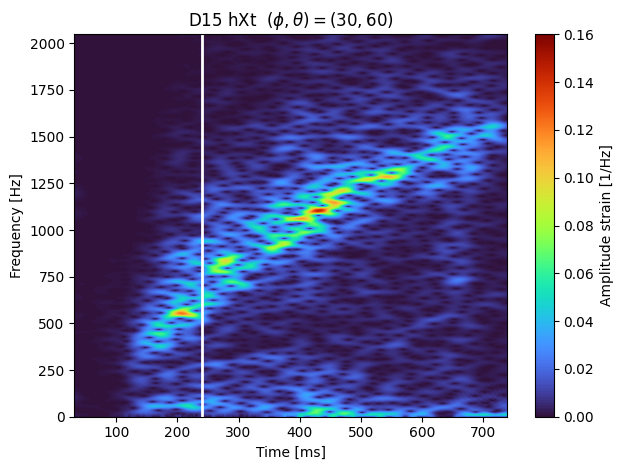

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (np.pi /6.0, np.pi / 3.0)  # Equator
xct = 240.7721

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt3060 / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, rhxt3060, kind='linear', bounds_error=False, fill_value=(rhxt3060[0], rhxt3060[-1]))
uniform_rhxt3060 = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_rhxt3060, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(xct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
#plt.xlim([min(pbt3060), max(pbt3060)])
plt.title(r"{0:s} hXt  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, phi_eq * 180.0 / np.pi, theta_eq * 180.0 / np.pi))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHXT_3060.png",dpi=400)
plt.show()

# **120Theta100Phi**

In [ ]:
import pandas as pd
with open('/content/D15_strain_theta120_phi100.txt','r') as f:
    lines = f.readlines()[1:]
data1=[[float(x) for x in line.split()]for line in lines]
df1 = pd.DataFrame(data1,columns=['pbt120100','rh+t120100','rhxt120100'])
print(df1.head())

   pbt120100  rh+t120100  rhxt120100
0   2.000261   -0.053812   -0.014056
1   2.200650   -0.035844    0.031578
2   2.400654   -0.035556    0.031697
3   2.600044   -0.035065    0.032015
4   2.800372   -0.034985    0.031835


In [ ]:
pbt120100 = df1['pbt120100'].to_numpy()
print(pbt120100)
rhpt120100 = df1['rh+t120100'].to_numpy()
print(rhpt120100)
rhxt120100 = df1['rhxt120100'].to_numpy()
print(rhxt120100)

[  2.0002608   2.2006504   2.400654  ... 741.0003    741.20015
 741.40061  ]
[-0.05381214 -0.03584355 -0.03555588 ... -3.6941033  -3.40104414
 -4.23826819]
[-0.01405577  0.03157813  0.03169664 ... -3.37567568 -2.84570763
 -3.05743139]


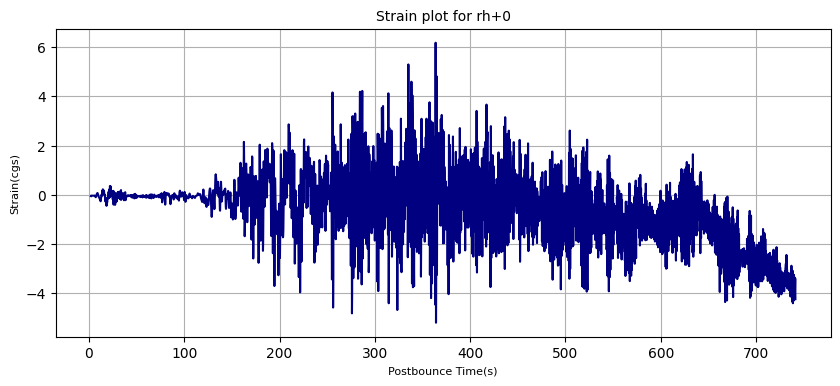

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(pbt120100,rhpt120100,color='navy')
#plt.xlim(left=100, right=740)
plt.xlabel("Postbounce Time(s)", fontsize=8)
plt.ylabel("Strain(cgs)", fontsize=8)
plt.title("Strain plot for rh+0", fontsize=10)
plt.grid(True)
plt.show()

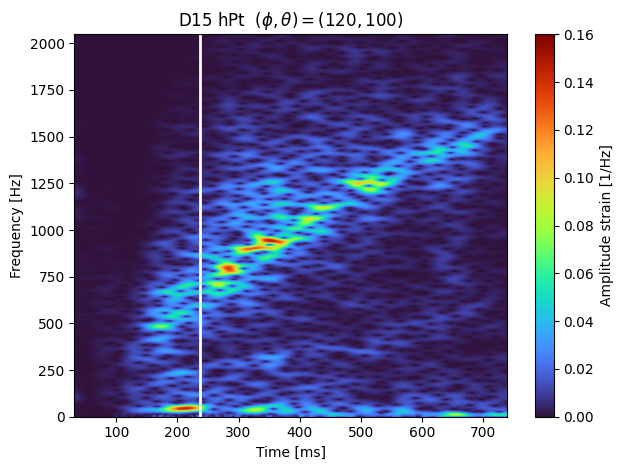

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (0.0, np.pi / 2.0)  # Equator
pct = 237.0304

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt120100 / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, rhpt120100, kind='linear', bounds_error=False, fill_value=(rhpt120100[0], rhpt120100[-1]))
uniform_rhpt120100 = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_rhpt120100, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(pct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
#plt.xlim([min(pbt3060), max(pbt3060)])
plt.title(r"{0:s} hPt  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, 120, 100))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHPT_120100.png",dpi=400)
plt.show()

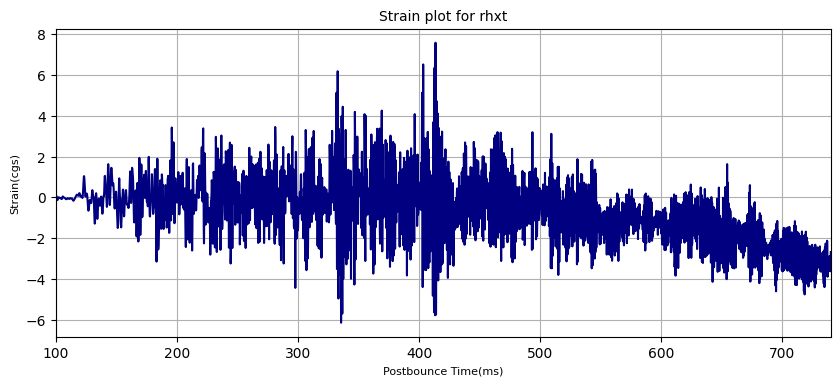

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(pbt120100,rhxt120100,color='navy')
plt.xlim(left=100, right=740)
plt.xlabel("Postbounce Time(ms)", fontsize=8)
plt.ylabel("Strain(cgs)", fontsize=8)
plt.title("Strain plot for rhxt", fontsize=10)
plt.grid(True)
plt.show()

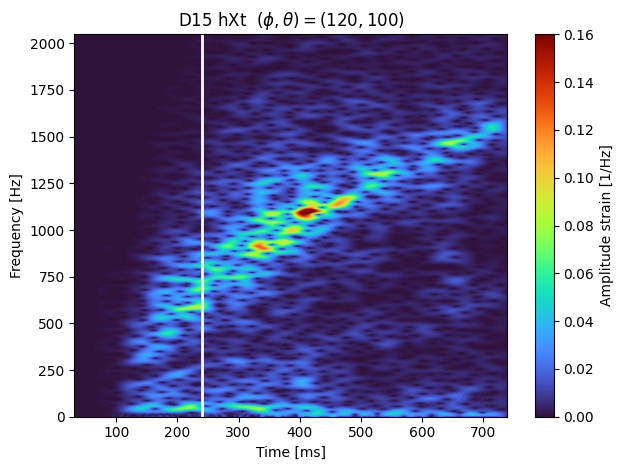

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

name = "D15"
wnd = "hamming"
nfft = 4 * 512
nperseg = 256
noverlap = 256 - 5
fs = 4096  # Sampling frequency in Hz
(phi_eq, theta_eq) = (0.0, np.pi / 2.0)  # Equator
xct = 240.7721

# Convert pbt from milliseconds to seconds
pbt_seconds = pbt120100 / 1000.0

# Define padding slightly before and after pbt range
window_duration = nperseg / fs
start_time = pbt_seconds[0] - window_duration / 2
end_time = pbt_seconds[-1] + window_duration / 2

# Clip to zero to avoid negative start times
start_time = max(start_time, 0.0)

# Uniform time array for interpolation
uniform_time = np.arange(start_time, end_time, 1 / fs)

# Interpolation with edge value fill (to avoid white bands)
interp_func = interp1d(pbt_seconds, rhxt120100, kind='linear', bounds_error=False, fill_value=(rhxt120100[0], rhxt120100[-1]))
uniform_rhxt120100 = interp_func(uniform_time)

# Compute spectrogram
fxx, txx, Sxx = signal.spectrogram(uniform_rhxt120100, fs, window=wnd, nfft=nfft,
                                   nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# Align time axis in milliseconds
txx_shifted = txx + uniform_time[0]

# Plotting
plt.figure()
plt.pcolormesh(txx_shifted * 1000, fxx, Sxx, shading='gouraud', cmap='turbo', vmin=0, vmax=0.16)
plt.axvline(xct, color='white', linestyle='-', linewidth=2)
cbar = plt.colorbar()
cbar.set_label('Amplitude strain [1/Hz]')
plt.ylim([0, 2048])
#plt.xlim([min(pbt3060), max(pbt3060)])
plt.title(r"{0:s} hXt  $(\phi,\theta)=({1:.0f}, {2:.0f})$".format(name, 120, 100))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(name + "_A100_RHXT_120100.png",dpi=400)
plt.show()